# Conhecendo os dados

Para entender como o bitcoin se comporta ao longo do tempo e realizar a predição de preços, é necessário, pelo menos, de sua série histórica diária. Além disso, alguns fatores podem influenciar no preço da criptomoeda e explicar sua variação, portanto serão estudados como potenciais covariáveis para o modelo.

## Sumário do notebook:
   1. Definição do ambiente
   2. Coleta dos dados
   3. Análise exploratória

-----------

## 1. Definição do ambiente

### Bibliotecas

In [ ]:
!pip install swifter
!pip install pandas_datareader
!pip install pytrends
!pip install dash
!pip install nasdaq-data-link
!pip install fundingrate
!pip install jupyter-dash

In [32]:
import pandas as pd
import numpy as np

import datetime as dt
from dateutil.relativedelta import *

import pandas_datareader.data as web
from pytrends.request import TrendReq
import nasdaqdatalink
from fundingrate import funding_dydx

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
from jupyter_dash import JupyterDash

import swifter

from sklearn.preprocessing import MinMaxScaler

In [33]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.expand_frame_repr', True)
# warnings.simplefilter(action='ignore', category=FutureWarning)

### Variáveis globais

In [34]:
#@title parâmetros de formatação dos gráficos {display-mode: "form"}
plotly_kwargs = dict(
    title_x=0.5,
    autosize=False,
    plot_bgcolor='white',
    margin=dict(l=2, r=10, t=30, b=2),
    width=1000,
    height=500,
    hovermode='x unified',
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    )
)

In [35]:
cores_tema = {
   'verde_claro': '#8DD8D3',
   'verde_escuro': '#599191', 
   'azul_petroleo': '#0B6374',
   'cinza_escuro': '#424242',
   'azul_bic': '#27278B', 
    'azul':'#1b86b9',
   'laranja': '#C0791B',  
   'vermelho': '#FD5B58', 
   'rosa': '#D558AB',
   'amarelado': '#D7E6A3'
}

In [36]:
dt_fim = pd.to_datetime('2022-11-17')
periodo = pd.to_datetime([dt_fim + relativedelta(years=-5), dt_fim])

### Funções úteis

In [37]:
def create_corr_plot(series, nlags=None, plot_pacf=False):
    corr_array = pacf(series.dropna(), nlags=nlags, alpha=0.05) if plot_pacf else acf(series.dropna(), nlags=nlags, alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title, **plotly_kwargs)
    
    return fig

-----------

## 2. Coleta dos dados

**Bases de dados históricas:**

As bases de dados históricas contém registros por data

- `BTC - Bitcoin`: essa é a base principal, que contém o histórico de preços da criptomoeda BTC ao longo do tempo e também o volume de transações.
- `Tether`: preço da Tether (USDT), a maior stablecoin do universo dos ativos digitais, com alta capitalização de mercado - maior do que a grande maioria das criptomoedas.
- `Ether`: preço da Ether (ETH), nome dado ao token nativo do blockchain Ethereum e a segunda maior criptomoeda do mundo em valor de mercado.
- `NDXT`: índice NDXT — que reúne as 100 maiores empresas de tecnologia listada na Nasdaq.
- `SP500`: S&P 500, abreviação de Standard & Poor's 500, é um índice composto por quinhentos ativos cotados nas bolsas de NYSE ou NASDAQ, qualificados devido ao seu tamanho de mercado, sua liquidez e sua representação de grupo industrial.
- `USD`: preço do dólar (referente ao real) no período analisado.
- `Pytrends - btc_iot`: interesse relativo de pesquisas sobre o termo bitcoin no google ao longo do tempo 
- `Hash Rate`: medida usada para calcular a velocidade de resolução de um código da blockchain. O hashrate pode indicar queda na mineração ou fraqueza no mercado, causando pressão descendente no preço


**Variável Target:**

Como queremos predizer o preço de fechamento ajustado da bitcoin, nossa _variável target_ é `Adj Close`, da base BTC. A nomenclatura da variável será alterada para `btc`.

**Dicionário das colunas**:

As bases btc, tether, ether, ndxt e sp500, são extraídas da mesma fonte e possuem as mesmas colunas, descritas abaixo:
1. `Date`: É a a coluna de index, que representa a data associada ao preço daquele registro.
2. `Close`: O preço de fechamento da BTC no respectivo dia, ou sejam o último preço no qual a BTC foi vendida naquele dia.
3. `Open`: O preço de abertura da BTC no respectivo dia, ou sejam o primeiro preço no qual a BTC foi vendida naquele dia.
4. `High`: O maior preço que a BTC foi vendida no respectivo dia.
5. `Low`:  O menor preço que a BTC foi vendida no respectivo dia.
6. `Volume`: O número de transações totais naquele dia.
7. `Adj Close`: O preço de fechamento ajustado por dividendos e desdobramentos de ações.

A coluna `Adj Close`, representando o preço de fechameto ajustado, será a coluna priorizada para todas as variáveis. 

As demais bases de dados contém somente uma coluna referente à informação descrita no tópico de "bases de dados históricas", portanto, não serão repetidos aqui.

### 2.1. Bitcoin - Yahoo

In [38]:
btc = web.DataReader('BTC-USD', data_source='yahoo', start=periodo[0], end=periodo[1])

# Ajustando nomes das colunas
btc.columns = ['btc_' + c.lower() for c in btc.columns]
btc = btc.rename(columns={'btc_adj close':'btc'})

In [74]:
btc.shape

(1828, 6)

In [76]:
btc.head(3)

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc
Date,,,,,,
2017-11-17,8004.589844,7561.089844,7853.569824,7708.990234,4651670016,7708.990234
2017-11-18,7884.990234,7463.439941,7697.209961,7790.149902,3667190016,7790.149902
2017-11-19,8101.910156,7694.100098,7766.029785,8036.490234,3149319936,8036.490234


In [77]:
btc.tail(3)

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc
Date,,,,,,
2022-11-16,16960.294922,16430.111328,16884.341797,16669.439453,33925512989,16669.439453
2022-11-17,16726.439453,16460.683594,16670.425781,16687.517578,27868914022,16687.517578
2022-11-18,16947.058594,16564.611328,16687.912109,16697.777344,26862218609,16697.777344


A base histórica de bitcoins tem 1828 registros e 6 colunas, com seu histórico completo no período selecionado.

### 2.2. Yahoo - Outras criptomoedas + Indices Americanos

In [40]:
tickers = ['USDT-USD', 'ETH-USD'] + ["^NDXT", '^GSPC', "USDBRL=x"] # criptos + indices
ticker_names = ['usdt','eth', 'ndxt', 'sp500', 'usd']

In [81]:
df_yahoo = web.get_data_yahoo(tickers, start=periodo[0], end=periodo[1])["Adj Close"]
df_yahoo.columns=ticker_names

In [82]:
df_yahoo.head(3)

,usdt,eth,ndxt,sp500,usd
Date,,,,,
2017-11-17,1.00139,332.394012,4031.629883,2578.850098,3.2706
2017-11-18,1.00231,347.612000,NaN,NaN,NaN
2017-11-19,1.00244,354.385986,NaN,NaN,NaN


In [83]:
df_yahoo.tail(3)

,usdt,eth,ndxt,sp500,usd
Date,,,,,
2022-11-17,0.999402,1200.808594,6078.709961,3946.560059,5.3990
2022-11-18,0.999163,1212.300293,NaN,NaN,5.4221
2022-11-19,NaN,NaN,NaN,NaN,5.3827


Para essa base, o dado é diário mas já observamos coletas faltantes que devem ser tratadas posteriormente.
Observa-se também que o filtro de data final da função não funciona muito bem, mas o caso será tratado posteriormente para todas as bases, pois o problema está na função (outros testes foram feitos).

In [43]:
df_yahoo.describe()

,usdt,eth,ndxt,sp500,usd
count,1828.000000,1828.000000,1259.000000,1259.000000,1306.000000
mean,1.001591,1131.236136,6021.373109,3420.030182,4.613303
std,0.005766,1203.097282,1748.625487,675.156441,0.796489
min,0.966644,84.308296,3457.919922,2237.399902,3.145100
25%,0.999982,209.034111,4393.555176,2821.954956,3.865525
50%,1.000500,478.433487,5643.189941,3224.729980,4.932600
75%,1.002497,1802.185455,7543.064941,4018.845093,5.323050
max,1.077880,4812.087402,9855.419922,4796.560059,5.886400


### 2.3. Pytrends - interesse ao longo do tempo

In [44]:
# Conexão com google
bittrends = TrendReq(hl='en-US', tz=360) 

# Puxando dados
bittrends.build_payload(['bitcoin'], cat=0, timeframe=" ".join(periodo.astype(str)), geo='') 
btc_iot = bittrends.interest_over_time() 

# Filtro 
btc_iot = btc_iot[~btc_iot['isPartial']]

# Ajustando colunas
btc_iot.index.names=['Date']
btc_iot = btc_iot.rename(columns={'bitcoin':'iot'}).drop(columns=['isPartial'])

In [89]:
btc_iot.head(3)

,iot
Date,
2017-11-19,28
2017-11-26,64
2017-12-03,88


In [90]:
btc_iot.tail(3)

,iot
Date,
2022-10-23,13
2022-10-30,14
2022-11-06,27


A base de interesses de pesquisa é semanal, portanto deverá ser preenchida seguindo alguma estratégia para ter periodicidade diária. Também percebe-se que a atualização é mais demorada desses dados, apesar da data máxima ser 17/11, a última atualização é 06/11, o que pode prejudicar uma previsão diária.

### 2.4. Hash rate

Fonte: https://data.nasdaq.com/

In [46]:
hash_rate = nasdaqdatalink.get('BCHAIN/HRATE', start_date=periodo[0], end_date=periodo[1])
hash_rate = hash_rate.rename(columns={'Value':'hash_rate'})

In [91]:
hash_rate.head(3)

,hash_rate
Date,
2017-11-17,1.132691e+07
2017-11-18,9.224307e+06
2017-11-19,1.085213e+07


In [92]:
hash_rate.tail(3)

,hash_rate
Date,
2022-11-15,2.832561e+08
2022-11-16,2.741188e+08
2022-11-17,2.521893e+08


Os dados parecem ser estruturados e estarem corretos.

--------------

## 3. Unificação das bases

In [50]:
df_list = [btc, df_yahoo, btc_iot, hash_rate]

Ajuste de index para o join

In [51]:
df_concat = []
for df in df_list:
    # Ajuste de index para o join
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    
    # Filtro de datas
    df = df.loc[(df.index>=periodo[0]) & (df.index<=periodo[1])]
    
    df_concat.append(df)

In [52]:
df_all = pd.concat(df_concat, axis=1)

In [53]:
df_all.head(3)

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc,usdt,eth,ndxt,sp500,usd,iot,hash_rate,funding_rate
Date,,,,,,,,,,,,,,
2017-11-17,8004.589844,7561.089844,7853.569824,7708.990234,4651670016,7708.990234,1.001390,332.394012,4031.629883,2578.850098,3.2706,NaN,1.132691e+07,NaN
2017-11-18,7884.990234,7463.439941,7697.209961,7790.149902,3667190016,7790.149902,1.002310,347.612000,NaN,NaN,NaN,NaN,9.224307e+06,NaN
2017-11-19,8101.910156,7694.100098,7766.029785,8036.490234,3149319936,8036.490234,1.002440,354.385986,NaN,NaN,NaN,28.0,1.085213e+07,NaN
2017-11-20,8336.860352,7949.359863,8039.069824,8200.639648,3488450048,8200.639648,1.001920,366.730011,4044.050049,2582.139893,3.2545,NaN,1.186951e+07,NaN
2017-11-21,8348.660156,7762.709961,8205.740234,8071.259766,4277609984,8071.259766,0.996047,360.401001,4076.659912,2599.030029,3.2540,NaN,1.173386e+07,NaN


In [54]:
df_all.tail(3)

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc,usdt,eth,ndxt,sp500,usd,iot,hash_rate,funding_rate
Date,,,,,,,,,,,,,,
2022-11-13,16920.765625,16320.634766,16799.722656,16353.365234,27209183682,16353.365234,0.998755,1221.819214,NaN,NaN,NaN,NaN,2.357422e+08,NaN
2022-11-14,17109.324219,15872.941406,16352.028320,16618.199219,49630243054,16618.199219,0.999013,1241.604248,6165.009766,3957.250000,5.279059,NaN,2.247774e+08,NaN
2022-11-15,17051.962891,16542.550781,16617.484375,16884.613281,36599436183,16884.613281,0.999130,1251.736206,6344.140137,3991.729980,5.331200,NaN,2.832561e+08,-0.000054
2022-11-16,16960.294922,16430.111328,16884.341797,16669.439453,33925512989,16669.439453,0.999229,1215.602539,6121.200195,3958.790039,5.331700,NaN,2.741188e+08,-0.000040
2022-11-17,16726.439453,16460.683594,16670.425781,16687.517578,27868914022,16687.517578,0.999402,1200.808594,6078.709961,3946.560059,5.399000,NaN,2.521893e+08,-0.000030


Essa base será utilizada para estudos e modelagem, portanto, será salva no S3, no bucket raw, que serão os dados antes de realizar feature engineering e correções.

### 3.1. Correção de datas ausentes

Para ter certeza que não há datas faltando no dataframe, foi realizado o _reindex_ do dataframe de acordo com o intervalo de datas esperado.

In [55]:
print(df_all.shape)

# Para ter certeza que não há buracos no dataframe série
df_all = df_all.apply(lambda group: group.reindex(pd.date_range(periodo[0], periodo[1], freq='D'), 
                                                  #method='nearest' - vou deixar o método default: none, para que não haja preenchimetnos inadequados
                                                  )).sort_index()

print(df_all.shape)

(1827, 14)
(1827, 14)


Não havia buracos no datafreme, pois não houve mudança de tamanho.

### 3.2. Salvamento da base no S3

### [A DEFINIR ONDE] Interpolação de valores faltantes no meio da série

In [59]:
# df_all = df_all.apply(lambda x: x.interpolate(method='time', ))
# df_all = df_all.fillna(df_all.rolling(6,min_periods=1).mean())

----------------

## 4. Análise exploratória

### 4.1. A bitcoin

### 4.2. Gráficos das séries x BTC

In [57]:
variaveis = [x for x in df_all.columns if not 'btc' in x]

In [72]:
app = JupyterDash('Correlações')

app.layout = html.Div([
    html.H4("Análise do histórico de variáveis x Bitcoin"),
    
    html.Div(className='row',children=[
        html.Label(['Variáveis:'], style={'font-weight': 'bold', "text-align": "center"}),
        html.Div(children= dcc.Dropdown(
            id='y-axis', 
            options=variaveis,
            value='usd', 
            searchable=False,
            clearable=True
        ), style=dict(width='15%'))], style=dict(display='flex')),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    Input("y-axis", "value"))

def generate_chart(y):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(x=df_all.index, y=df_all['btc'], name='BTC', 
                             line=dict(color=cores_tema['verde_escuro'], width=1.2)))
    
    fig.add_trace(go.Scatter(x=df_all.index, y=df_all[y], name=y,
                             line=dict(color=cores_tema['amarelado'], width=1.2)),secondary_y=True)

    fig.update_traces(mode='lines')
    fig.update_layout(title='<b>Comparação BTC e covariáveis 2017-2022</b>', **plotly_kwargs)

    return fig

app.run_server(mode='inline', debug=True, use_reloader=False, port=8081)


## 5. Correlações

### 5.1. Correlação com a resposta no tempo x

In [28]:
cols_cov = df_all.columns[~df_all.columns.str.contains('btc_')]
df_cov = df_all[cols_cov]

In [29]:
df_corr = df_cov.corr()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



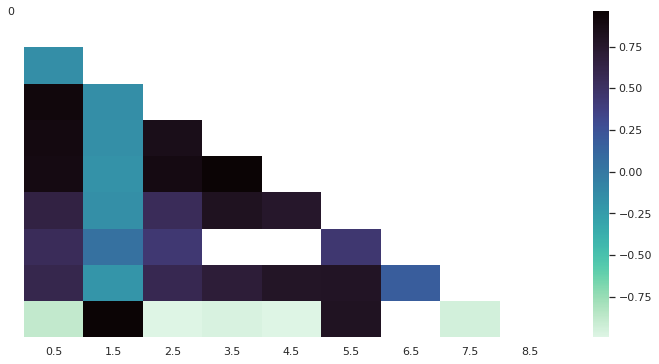

In [30]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})

mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig = sns.heatmap(df_corr, annot=True, fmt='.1f', cmap='mako_r', mask=mask, annot_kws={'fontdict':{'fontsize':14}})
fig.set_ylabel("",fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.show(fig)

Aqui já percebemos que funding rate e usd theter não influenciam fortemente a BTC no mesmo período.

In [ ]:
# filtrando as correlações maiores que +0.6 e menores que -0.6
corr_forte = df_corr[(df_corr > 0.65) | (df_corr < -0.65)]

# substituindo os valores das autocorrelações
corr_forte.replace(1,np.nan, inplace=True)

# retiando as linhas e colunas sem alta correlação
corr_forte.dropna(how='all', inplace=True, axis=1)
corr_forte.dropna(how='all', inplace=True)

plt.tick_params(axis='both', which='major', labelsize=14)

if len(corr_forte) :
  mask = np.triu(np.ones_like(corr_forte, dtype=bool))
  plt.show(sns.heatmap(corr_forte, annot=True, cmap='mako_r', mask=mask, annot_kws={'fontdict':{'fontsize':14}}));
else:
  print('Não há correlações significativas no conjunto de dados.')

Também devemos nos atentara ao uso da `eth` como covariável, por sua correlação com outras covariáveis e assim, podendo gerar multicolinearidade. Escolhemos `sp500` como covariável pois, além de ter alta correlação com `btc` também tem alta correlação com as demais.

### 5.2. Correlação com a resposta em lag

In [ ]:
lags = list(range(0,8))
mm = list(range(1,8))

In [ ]:
df_lag_mm = df_cov
for l in lags:
    for m in mm:
        df_tmp = df_cov.drop(columns='btc').swifter.apply(lambda x: x.shift(l).rolling(m).mean())
        df_tmp.columns = [c + '-lag' + str(l) + '_mm' + str(m) for c in df_tmp.columns]
        
        df_lag_mm = pd.concat([df_lag_mm, df_tmp], axis=1)

In [ ]:
df_lag_mm2 = df_lag_mm.melt(id_vars = 'btc', ignore_index=False, var_name='var', value_name='vlr')
df_lag_mm2[['var', 'lag_mm']] = df_lag_mm2['var'].str.split('-',expand=True)

In [ ]:
df_corr_lag_mm = (
    df_lag_mm2
    .groupby(['var', 'lag_mm']).corr().reset_index()
    .query('level_2=="btc"').drop(columns=['btc', 'level_2'])
    .sort_values(['var', 'lag_mm', 'vlr'], ascending=False)
)

In [ ]:
df_corr_lag_mm.groupby(['var'])['vlr'].max()

Mesmo com todas as transformações, observamos que as duas variáveis citadas antes, `funding_rate` e `usdt` não possuem correlação com a variável resposta (`btc`), portanto serão descartadas do modelo. Além disso, a variável `iot` possui correlação baixa e será também desconsiderada.

In [ ]:
df_corr_lag_mm[~df_corr_lag_mm['var'].isin(['iot', 'usdt', 'funding_rate'])].groupby('var').describe()

Observamos também que, mesmo com as transformações de lag ou média móvel caso haja necessidade (se nossa previsão for realizada sem a projeção das covariáveis), ainda temos correlação significativa para o modelo. Isso pode se dar devido à interpolação feita para preenchimento dos dados.
Também observamos que a correlação não muda drasticamente entre as transformações, portanto podemos escolher qualquer uma delas para seguir com o modelo.

In [ ]:
%%capture
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install cmasher
!pip install pytrends

In [ ]:
df_corr_lag_mm[df_corr_lag_mm['var']=='sp500']